# doc2vec modelling of abstracts

This goes through a single iteration.

1. Prepare training corpus
2. Train doc2vec model 
3. Reduce model dimensions and visualize

Load libraries.

In [2]:
import glob
import os
from sklearn.model_selection import train_test_split
import numpy as np
from contextlib import contextmanager
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from timeit import default_timer as timer
import multiprocessing as mp
from datetime import timedelta
import pandas as pd

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [ ]:

import nltk
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import time

import seaborn as sns

## 1. Prepare training corpus 


Since we will be training a model with hyperparameters that need to be tuned, we need a validation set along with a test set.

- **Training Dataset**: The sample of data used to fit the model.
- **Validation Dataset**: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters.
- **Test Dataset**: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

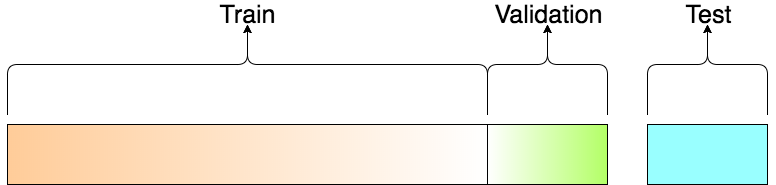
Image source: https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

Usually the Test set is curated to provide the gold standard, the carefully sampled data that spans the various classes that the model would face, when used in the real world. As with Kaggle, the final test set is released to the public usually only when a contest is nearing the end. However, here it is not curated, but randomly selected. It would be good in the future to have an astrophysicist carefully curate this test set to select a triplet set to test how well the model is able to detect the relationships within.

Here we randomly split our dataset into 2 — Train and Test — using the common 80:20 ratio. We set aside the Test set. We then randomly split the Train set, again using the 80:20 ratio, into the actual Train and Validation sets. We will iteratively train the model and validate it on these two sets. Then we will test the final model on the Test set. 

*Note: There is a [discussion](https://towardsdatascience.com/finally-why-we-use-an-80-20-split-for-training-and-test-data-plus-an-alternative-method-oh-yes-edc77e96295d) on how to choose best ratio. Here we just go with the conventional split, which is 80:20. But for my dissertation it may be worth looking into alternative ratios such as the scaling law, although oftentimes the increase in performance is small.*

In [4]:
# Collect all filenames
filenames = np.array(glob.glob('/Volumes/BRIENNAKH/Thesis/data/2020_06_09_abstract_tokens/*.npy'))
print('Number of abstracts: ' + str(len(filenames)))

# Randomly shuffle
print('Randomly shuffling...')
np.random.shuffle(filenames)

# Split 80:20 (we will do this part iteratively later in cross-validation)
print('Splitting files into two subsets with a ratio of 80:20...')
train_data, test_data = train_test_split(filenames, test_size=0.2)
train_data, validation_data = train_test_split(train_data, test_size=0.2)
print('Number of abstracts for training: ' + str(len(train_data)))
print('Number of abstracts for testing: ' + str(len(test_data)))
print('Number of abstracts for validation: ' + str(len(validation_data)))

Number of abstracts: 159616
Randomly shuffling...
Splitting files into two subsets with a ratio of 80:20...
Number of abstracts for training: 102153
Number of abstracts for testing: 31924
Number of abstracts for validation: 25539


## 2. Train doc2vec model

To train the model, our corpus can be simply a list of documents, but for larger corpora, consider an iterable that streams the documents directly from disk/network. So we will create a function that will allow us to load and delete numpy files as we work with each.

In [5]:
class DocumentIterator(object):
    def load_documents(self):
        for filename in self.filenames: 
            loaded_file = np.load(filename)
            tag = os.path.splitext(os.path.basename(filename))[0]
            abstract = TaggedDocument(words=loaded_file, tags=[tag])
            try:
                yield abstract
            except Exception as e:
                print('Error!' + str(e))
            finally:
                del loaded_file
                # print('Closed ' + tag)
                
    def __init__(self, filenames):
        self.filenames = filenames
        self.documents = self.load_documents()

    def __iter__(self):
        self.generator = self.load_documents() # Reset the iterator
        return self
    
    def __next__(self):
        abstract = next(self.documents)
        return abstract
    
#for i in DocumentIterator(validation_data):
#    print(i)

Set up doc2vec model parameters.

- dm = 0 means "distributed bag of words" (PV-DBOW). dm = 1 means "distributed memory" (PV-DM)

Essentially, the vocabulary is a dictionary (accessible via model.wv.vocab) of all of the unique words extracted from the training corpus along with the count (e.g., model.wv.vocab['penalty'].count for counts for the word penalty).

In [ ]:
train_iterator = DocumentIterator(train_data)
start = timer()
model = Doc2Vec(train_iterator,
                vector_size=300,
                alpha=0.025,
                min_alpha=0.001, 
                min_count=1,
                workers=mp.cpu_count(),
                dm=1,
                epochs=40)
#model.save('d2v.model')
print('Model Saved')
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

In [ ]:
model

## 3. Reduce model dimensions and visualize

### Load model

In [ ]:
model = Doc2Vec.load('d2v.model')
print('Dimensions of each document in this model: ' + str(len(model[0])))

Get the document IDs.

In [ ]:
doc_tags = list(model.docvecs.doctags.keys())
len(doc_tags)

Get the documents from the model.

In [ ]:
docs = model[doc_tags]
len(docs)

### Generate labels

Load metadata.

In [ ]:
metadata = pd.read_csv('../data/2020_03_06_arxiv_metadata_astroph/arxiv_metadata_astroph.csv',
                       dtype={'filename': str,
                              'filename_parsed': str,
                              'identifier': str,
                              'updated': str,
                              'doi': str}, 
                       parse_dates=['date_retrieved'])

Collect categories from the metadata, only for those papers that were in our dataset. 

In [ ]:
categories = metadata[metadata['filename_parsed'].isin(doc_tags)]['categories'].str.split(' ')
categories

Generate labels for subdomains.

In [ ]:
acceptable_subdomains = ['astro-ph.SR',
                         'astro-ph.CO',
                         'astro-ph.GA',
                         'astro-ph.HE',
                         'astro-ph.EP',
                         'astro-ph.IM']

subdomain_names = ['Solar and Stellar Astrophysics', # for plot legend
                     'Cosmology and Nongalactic Astrophysics',
                     'Astrophysics of Galaxies',
                     'High Energy Astrophysical Phenomena',
                     'Earth and Planetary Astrophysics',
                     'Instrumentation and Methods for Astrophysics'] 

acceptable_categories = ['astro-ph']
acceptable_categories += acceptable_subdomains

category_names = ['Astrophysics']
category_names += subdomain_names

Find each paper's author-assigned subcategory. If the paper has none, remove it from the data. We will not plot it. 

In [ ]:
labels = []
indexes_to_drop = []

# For each paper
for i, _ in enumerate(categories):
    for j,_ in enumerate(categories[i]):
        assigned = False
        
        # If category is a subcategory, select it as the paper's label (this grabs the first one)
        if categories[i][j] in acceptable_subdomains:
            labels.append(subdomain_names[acceptable_subdomains.index(categories[i][j])])
            assigned = True
            break
            
        # If on last category,
        if j == (len(categories[i]) - 1) and not assigned: 
            indexes_to_drop.append(i)    
            
print('Dropping ' + str(len(indexes_to_drop)) + ' papers.')
print('Labels: ' + str(len(labels)))
pd.Series(labels).value_counts()

Also find each paper's assigned category (and subcategory, as this includes astro-ph). 

In [ ]:
labels_full = []

# For each paper, 
for i, _ in enumerate(categories): 
    for j,_ in enumerate(categories[i]):
        if categories[i][j] in acceptable_categories:
            labels_full.append(category_names[acceptable_categories.index(categories[i][j])])
            break
            
pd.Series(labels_full).value_counts()

Generate array of label colors (used for 3D plots, they have a different argument requirement). 

In [ ]:
colors = ['red', 'black', 'blue', 'purple', 'orange', 'yellow', 'green', 'brown']
label_indices = []
for label in labels:
    label_indices.append(subdomain_names.index(label))
label_indices

### PCA

Generate, from the original 300 dimensions, the first three principal components.

In [ ]:
pca = PCA(n_components=3)
pca_result_3 = pca.fit_transform(docs)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

The first three components account for about 4.44% of the variation in the entire dataset. This seems low. We will need to see if it is enough to visually set the different documents apart. We can do this by creating a scatterplot of the principal components and coloring each document's subdomain with a different color. If documents from the same subdomain are clustered together in groups, this would mean that the first three principal components actually tell us a great deal about the specific subdomains of documents.

Remove papers that don't have author-assigned subdomain. *(Would it be better to remove before PCA?)*

In [ ]:
pca_result_3.shape

In [ ]:
pca_result_3_mod = np.delete(pca_result_3, indexes_to_drop, axis=0)
pca_result_3_mod.shape

Visualize 2D.

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_result_3_mod[:,0],
    y=pca_result_3_mod[:,1],
    alpha=0.3,
    s=3,
    hue=labels,
    palette=sns.color_palette("hls", len(subdomain_names))
)

Visualize 3D.

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result_3_mod[:,0], 
    ys=pca_result_3_mod[:,1], 
    zs=pca_result_3_mod[:,2], 
    c=label_indices, 
    alpha=0.1,
    cmap=ListedColormap(sns.color_palette("hls", len(subdomain_names))),
    s=0.5
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

From the graphs we can see the first two components definitely hold some information, but not enough to set all of the documents apart. *Not sure if the two plots are colored the same. I tried, but it doesn't look the same. Would be helpful to somehow open up into the matplotlib interactive window and explore.*

### t-SNE

t-SNE is another technique that we can use to reduce the number of dimensions that may prove more helpful than PCA.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or Truncated SVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high.

Reduce from 300 dimensions to 50 using PCA.

In [ ]:
pca_full = PCA(n_components=50)
pca_result_full = pca_full.fit_transform(x_full)
len(pca_result_full)

Reduce from 50 dimensions to 2 using t-SNE. *Will need to reduce to 3 later.*

In [ ]:
tsne = TSNE(n_components=2, verbose=1)
x_tsne_full = tsne.fit_transform(pca_result_full)
np.save('tsne_full.npy', x_tsne_full)

If we have already reduced the model using t-SNE (which takes a few hours), load the reduced model.

In [ ]:
tsne_data = np.load('tsne_full.npy')
len(tsne_data)

Remove papers that don't have author-assigned subdomain. *(Would it be better to remove before t-SNE? Same question above with PCA.)*

In [ ]:
tsne_data_mod = np.delete(tsne_data, indexes_to_drop, axis=0)
len(tsne_data_mod)

Visualize in 2D.

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=[i[0] for i in tsne_data_mod],
    y=[i[1] for i in tsne_data_mod],
    alpha=0.3,
    s=3,
    hue=labels,
    legend='full',
    palette=sns.color_palette("hls", len(subdomain_names))
)

Visualize all categories in 2D.

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=[i[0] for i in tsne_data],
    y=[i[1] for i in tsne_data],
    alpha=0.3,
    hue=labels_full,
    s=3,
    legend='full',
    palette=sns.color_palette("hls", len(category_names))
)

*Could look at those astro-ph papers without subdomains to see if they are similar to whatever subdomain they were clustered into.*